# Calculations For Crime, Art, & Greenspace
[A descripton of the api endpoints]

---
**Step 0:** We begin by importing all the neccesary functionality we need for this project including tools for mapping, and api calling. We then set critical global variables such as api endpoints and the number of entries that each of these calls returns.

In [ ]:
#download request library, a bundle of code for APIs
import requests
import json
from pprint import pprint
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape, Point
import csv
from pandas.io.json import json_normalize

#api endpoints
art_endpoint = "https://data.seattle.gov/resource/j7sn-tdzk.json"
greenspace_endpoint = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/Public_and_Open_Spaces_in_Seattle_WFL1/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
crime_endpoint = "https://data.seattle.gov/resource/tazs-3rd5.json"
neighborhood_endpoint = "https://services.arcgis.com/ZOyb2t4B0UYuYNYH/arcgis/rest/services/nma_nhoods_main/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

#the number of entries for each api 
art_spaces_limit =  316
greenspace_limit = 3614
crime_limit = 997000

## Section 1 - Calling The APIs
**Step 1:** We are primarily concerned with the name of the art piece as well as it's location on the map -- this gives us the greatest number of art pieces to use in the comparision in this study. This block of code calls the public art endpoint and loops through the data to create a dictionary which associates the title of the piece with the shapely longitude/latitude points which will be used to cross reference the boundaries of the neighborhoods.   

In [246]:
#retrieves all data from the art endpoint and creates a dictionary that lists the name, date 
#and point of all art projects and counts the number of pieces that do not fit this data criteria 
art_limit = {"$select": "title, longitude, latitude",  
             "$limit" : art_spaces_limit}
art = requests.get(art_endpoint, params= art_limit )
art_data = art.json()
art_info = {}
for piece in art_data:
    point = Point(float(piece['longitude']), float(piece['latitude']))
    if piece.__contains__('title'):
        art_info[piece['title']] = {'point' : point}

**Step 2:** We will repeat similar procedures from step 1 to garner information about the greenspace throughout Seattle. We are mainly concerned with the park rating and the longitude and latitude it has. 

**Step 3:** We will repeat similar procedures from step 1 and 2 to garner information about the crime throughout Seattle. We are mainly foucsed on x, y ,z 

In [252]:
#retrieves all data from the policing database 
police_by_location = {}
police_limit = {"$select" :"MCPP, Offense, Longitude, Latitude"}
arrests = requests.get(crime_endpoint, params=police_limit)
crime_data = arrests.json()
district = 0;
pprint(crime_data[:1])


[{'Latitude': '47.649387230',
  'Longitude': '-122.385973723',
  'MCPP': 'MAGNOLIA',
  'Offense': 'Drug/Narcotic Violations'}]


## Section 2 - Neighborhood Locations

**Step 1:** Because the process I will be using to classify the location of art, greenspace, and crime involves comparing shapely information in mapping using longitude and lattitude, I first wanted to create a function to call to add the different types of [more description when this function get's completed]

In [247]:
def check_hood(response_data):
    hoods = requests.get(neighborhood_endpoint)
    hood_data = hoods.json()
    hit = 0
    for hood in hood_data['features']:
        hood_name = hood['properties']['L_HOOD']
        polygon = shape(hood['geometry'])
        for piece in response_data:
            point = art_info[piece]['point']
            if polygon.contains(point):
                print(hood_name + " " + piece)
                hit += 1

**Step 2:** Call the check_hood function for all three databases that have been queried for this study.

In [249]:
check_hood(art_info)
check_hood()

Ballard Coelacanths
Ballard Forms of Power
Ballard Ballard Boat
Ballard .01 - Weather Permitting   .02 - Flow
Ballard Witness Trees - What The Trees Have Seen
Ballard Ballard Gateway
Ballard Ballard Sculpture Garden
Ballard Catfish
Ballard Vagor I And Vagor II
Ballard Ballard Centennial Bell Tower
Ballard Atala Kivliktwok Okitun Dukik (The Golden Money Moon)
Beacon Hill East is West
Beacon Hill Equality
Beacon Hill .01 - Beacon Hill Discovery; .02 - Ravens Bill Downspouts
Beacon Hill Plynth and Pylon from the Project "Vista"
Beacon Hill Hydro Roots from the project "Vista"
Beacon Hill Dr. Jose P. Rizal
Beacon Hill Tidal Wave Story
Beacon Hill Salmon
Beacon Hill Sherwood Gillespie
Capitol Hill Untitled Cor-Ten Steel Sculpture
Capitol Hill Playform
Capitol Hill Contour
Capitol Hill Lantern Gateway
Capitol Hill House Finial
Capitol Hill Skyline Canopies
Capitol Hill Tulip Tree Mosaic
Capitol Hill Dancer's Series: Steps
Capitol Hill Homage in Green
Capitol Hill The Itinerant
Capitol Hill M

TypeError: check_hood() missing 1 required positional argument: 'response_data'

## Section 3 - Mapping (& Other Analysis!) 
Now that we have a better understanding of geolocation and distribution, it is time to get into the meat of our analysis. 

**Step 1:** 

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'art')

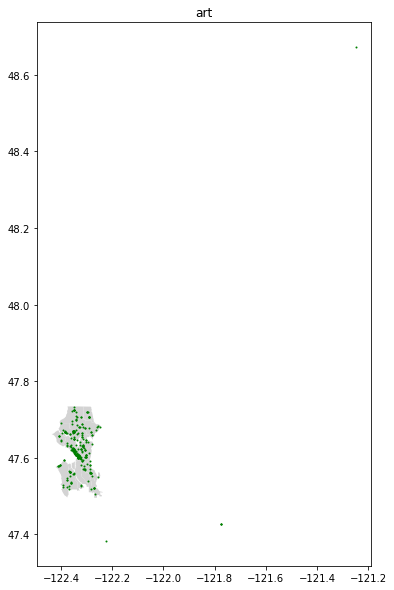

In [27]:
hoods = gpd.read_file(neighborhood_endpoint)
#hoods.to_crs(epsg=4326).plot()
df = pd.read_csv('Public_Art_Data.csv')
df.head()
crs= {'init': 'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry = geometry)

geo_df.head()
fig, ax = plt.subplots(figsize = (15,10))
hoods.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax, color='green', markersize=1)
ax.set_title("art")
